### This notebook demonstrates the use of the ATOMMIC transforms on the Calgary-Campinas 359 dataset.

#### Important! You need to have downloaded the CC359 dataset to properly run the notebook. For more information, please read [here](projects/REC/CC359/README.md).

In [1]:
import h5py
import torch
import matplotlib.pyplot as plt
import numpy as np

from atommic.collections.common.parts import fft, utils
from atommic.collections.common.parts.transforms import (
    Composer,
    Cropper,
    EstimateCoilSensitivityMaps,
    GeometricDecompositionCoilCompression,
    N2R,
    NoisePreWhitening,
    SSDU,
    SNREstimator,
    ZeroFillingPadding
)
from atommic.collections.motioncorrection.parts.motionsimulation import MotionSimulation

# Specify path where CC359 data are downloaded

In [2]:
parent_data_path = input("Please enter the (downloaded) data path: ")

# Specify data paths specific to CC359

In [3]:
subject = 'e14110s3_P59904.7.h5'

In [4]:
data_path = f'{parent_data_path}/calgary-campinas_version-1.0/CC359/Raw-data/Multi-channel/12-channel/Val/{subject}'
mask_path = f'{parent_data_path}/calgary-campinas_version-1.0/CC359/poisson_sampling_h5/Val/{subject}'

# Read the data

In [5]:
# load the k-space
kspace = h5py.File(data_path)['kspace'][()]

In [6]:
kspace.shape

(256, 218, 170, 24)

In [7]:
# necessary operation for the CC359 dataset
kspace = np.moveaxis(kspace[..., ::2] + 1j * kspace[..., 1::2], -1, 1)

In [8]:
kspace.shape

(256, 12, 218, 170)

In [9]:
# load the masks
mask = h5py.File(mask_path)

In [10]:
mask.keys()

<KeysViewHDF5 ['mask_10x', 'mask_5x']>

In [11]:
# pick a mask
mask_5x = mask['mask_5x'][()]

In [12]:
mask_5x.shape

(256, 218, 170)

In [13]:
# pick a slice
slice_idx = 100
kspace = kspace[slice_idx]
mask_5x = mask_5x[slice_idx]

In [14]:
# transform to tensor
kspace = utils.to_tensor(kspace)
mask_5x = utils.to_tensor(mask_5x).unsqueeze(0).unsqueeze(-1)

In [15]:
masked_kspace = kspace * mask_5x

In [16]:
# initialize general parameters for transformations
fft_centered = False
fft_normalization = 'backward'
spatial_dims = (-2, -1)
coil_dim = 0

start = 10
patch_length = 30 + start
patch_size = [start, patch_length, start, patch_length]

num_coils = kspace.shape[coil_dim]

In [17]:
# initialize the SNR estimator to compare the images along transformations
snr_estimator = SNREstimator(
    patch_size=patch_size,
    apply_ifft=False,
    fft_centered=fft_centered,
    fft_normalization=fft_normalization,
    spatial_dims=spatial_dims,
    coil_dim=coil_dim,
    multicoil=True,
)

In [18]:
# apply the IFFT
imspace = fft.ifft2(kspace, fft_centered, fft_normalization, spatial_dims)
masked_imspace = fft.ifft2(masked_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
imspace = imspace / torch.max(torch.abs(imspace))
masked_imspace = masked_imspace / torch.max(torch.abs(masked_imspace))
# compute the SNR of the image
imspace_snr = snr_estimator(imspace)
masked_imspace_snr = snr_estimator(masked_imspace)
# stack all coils for visualization
imspace_all_coils = torch.view_as_complex(torch.cat([imspace[i] for i in range(num_coils)], dim=-2))
masked_imspace_all_coils = torch.view_as_complex(torch.cat([masked_imspace[i] for i in range(num_coils)], dim=-2))
# compute the covariance matrix
covariance_imspace_all_coils = torch.abs(imspace_all_coils) @ torch.abs(imspace_all_coils).conj().T
covariance_masked_imspace_all_coils = torch.abs(masked_imspace_all_coils) @ torch.abs(masked_imspace_all_coils).conj().T
# compute the RSS target
rss_target = utils.rss_complex(imspace, coil_dim)
masked_rss_target = utils.rss_complex(masked_imspace, coil_dim)

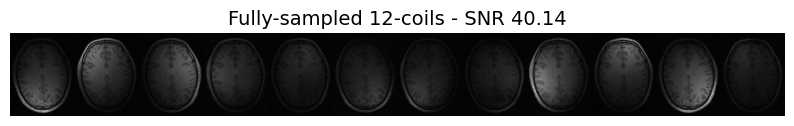

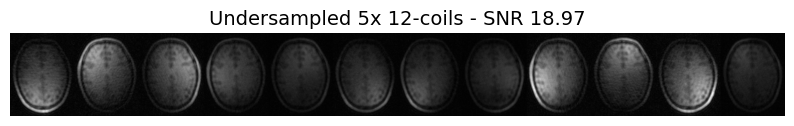

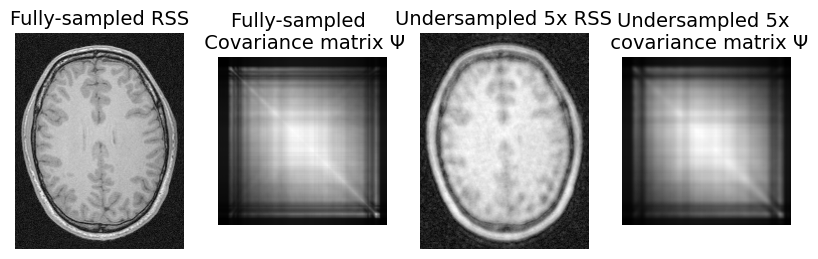

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(torch.abs(imspace_all_coils), cmap='gray')
plt.title(f'Fully-sampled {num_coils}-coils - SNR {imspace_snr:.2f}', fontsize=14)
plt.axis('off')
plt.figure(figsize=(10, 10))
plt.imshow(torch.abs(masked_imspace_all_coils), cmap='gray')
plt.title(f'Undersampled 5x {num_coils}-coils - SNR {masked_imspace_snr:.2f}', fontsize=14)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.imshow(torch.abs(rss_target), cmap='gray')
plt.title('Fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(covariance_imspace_all_coils, cmap='gray')
plt.title('Fully-sampled \n Covariance matrix Ψ', fontsize=14)
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(torch.abs(masked_rss_target), cmap='gray')
plt.title('Undersampled 5x RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(covariance_masked_imspace_all_coils, cmap='gray')
plt.title('Undersampled 5x \n covariance matrix Ψ', fontsize=14)
plt.axis('off')
plt.show()

***
# ATOMMIC Transforms
***

# Cropping

In [20]:
# initialize the transformer
cropping = Cropper(
    cropping_size=[160, 160],
    fft_centered=fft_centered,
    fft_normalization=fft_normalization,
    spatial_dims=spatial_dims,
)

In [21]:
# call the transformer
cropped_kspace = cropping(kspace)
cropped_imspace = cropping(imspace)
# apply the IFFT
cropped_kspace_imspace = fft.ifft2(cropped_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
cropped_kspace_imspace = cropped_kspace_imspace / torch.max(torch.abs(cropped_kspace_imspace))
cropped_imspace = cropped_imspace / torch.max(torch.abs(cropped_imspace))
# compute the RSS target
cropped_kspace_imspace_rss_target = utils.rss_complex(cropped_kspace_imspace, coil_dim)
cropped_imspace_rss_target = utils.rss_complex(cropped_imspace, coil_dim)

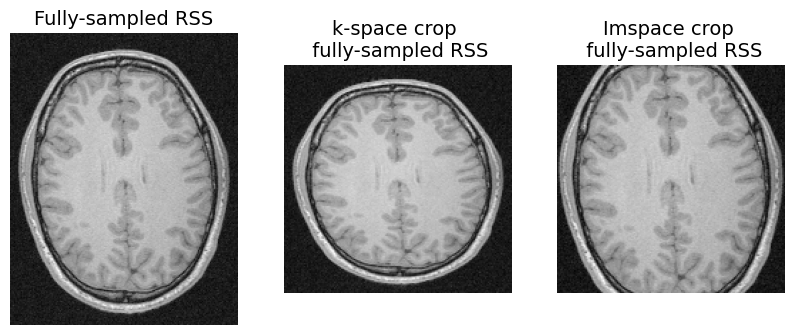

In [22]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rss_target, cmap='gray')
plt.title('Fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cropped_kspace_imspace_rss_target, cmap='gray')
plt.title('k-space crop \n fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cropped_imspace_rss_target, cmap='gray')
plt.title('Imspace crop \n fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.show()

# Estimation of Coil Sensitivity Maps

In [23]:
# initialize the transformer
coil_sensitivity_maps_estimator = EstimateCoilSensitivityMaps(
    coil_sensitivity_maps_type="rss",
    gaussian_sigma=None,
    espirit_threshold=0.05,
    espirit_kernel_size=6,
    espirit_crop=0.95,
    espirit_max_iters=30,
    fft_centered=fft_centered,
    fft_normalization=fft_normalization,
    spatial_dims=spatial_dims,
    coil_dim=coil_dim,
)

In [24]:
# call the transformer
coil_sensitivity_maps = coil_sensitivity_maps_estimator(kspace)
# normalize the image for consistent visualization
coil_sensitivity_maps = coil_sensitivity_maps / torch.max(torch.abs(coil_sensitivity_maps))
# compute the RSS target
coil_sensitivity_maps_rss_target = utils.rss_complex(coil_sensitivity_maps, coil_dim)
# compute the SENSE target
sense_target = torch.abs(torch.view_as_complex(utils.sense(imspace, coil_sensitivity_maps, coil_dim)))

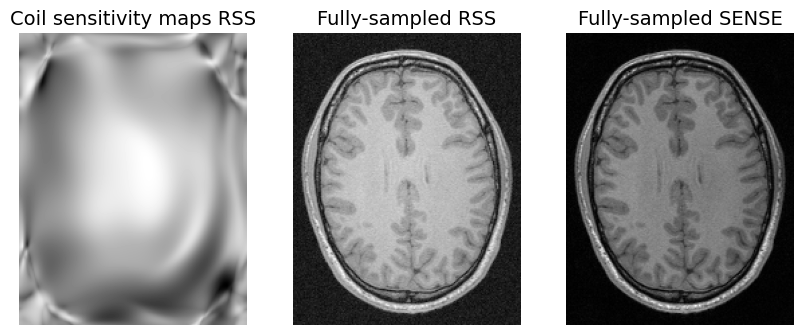

In [25]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(coil_sensitivity_maps_rss_target, cmap='gray')
plt.title('Coil sensitivity maps RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(rss_target, cmap='gray')
plt.title('Fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(sense_target, cmap='gray')
plt.title('Fully-sampled SENSE', fontsize=14)
plt.axis('off')
plt.show()

# Geometric Decomposition Coil Compression

In [26]:
# initialize the transformer
virtual_coils = 4
gdcc = GeometricDecompositionCoilCompression(
    virtual_coils=virtual_coils,
    calib_lines=6,
    align_data=True,
    fft_centered=fft_centered,
    fft_normalization=fft_normalization,
    spatial_dims=spatial_dims,
)

In [27]:
# call the transformer
coil_compressed_kspace = gdcc(kspace)
# apply the IFFT
coil_compressed_imspace = fft.ifft2(coil_compressed_kspace, fft_centered, fft_normalization, spatial_dims)
coil_compressed_imspace = torch.flip(coil_compressed_imspace, [2])
# normalize the image for consistent visualization
coil_compressed_imspace = coil_compressed_imspace / torch.max(torch.abs(coil_compressed_imspace))
# compute the SNR for the transformed image
coil_compressed_imspace_snr = snr_estimator(coil_compressed_imspace)
# stack all coils for visualization
coil_compressed_imspace_all_coils = torch.view_as_complex(torch.cat([coil_compressed_imspace[i] for i in range(virtual_coils)], dim=-2))
# compute the SNR for the transformed image
coil_compressed_rss_target = utils.rss_complex(coil_compressed_imspace, coil_dim)

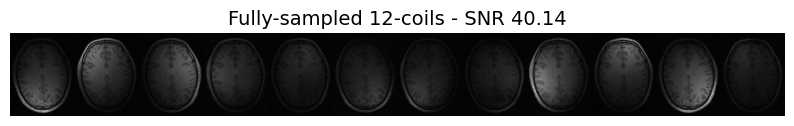

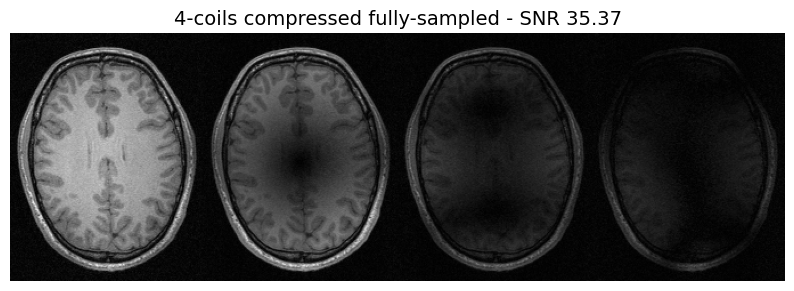

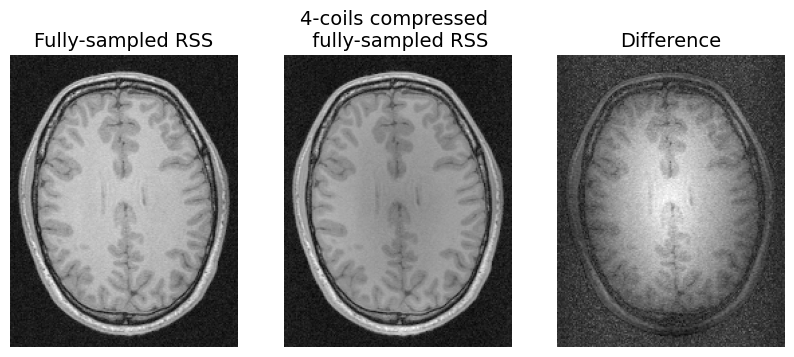

In [28]:
plt.figure(figsize=(10, 10))
plt.imshow(torch.abs(imspace_all_coils), cmap='gray')
plt.title(f'Fully-sampled {num_coils}-coils - SNR {imspace_snr:.2f}', fontsize=14)
plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(torch.abs(coil_compressed_imspace_all_coils), cmap='gray')
plt.title(f'{virtual_coils}-coils compressed fully-sampled - SNR {coil_compressed_imspace_snr:.2f}', fontsize=14)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rss_target, cmap='gray')
plt.title('Fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(coil_compressed_rss_target, cmap='gray')
plt.title(f'{virtual_coils}-coils compressed \n fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(torch.abs(rss_target) - torch.abs(coil_compressed_rss_target), cmap='gray')
plt.title('Difference', fontsize=14)
plt.axis('off')
plt.show()

# Motion Simulation

In [29]:
# initialize the transformer
random_motion = MotionSimulation(
    motion_type="piecewise_transient",
    angle=10,
    translation=10,
    center_percentage=0.02,
    motion_percentage=[30, 30],
    num_segments=8,
    random_num_segments=False,
    non_uniform=False,
    spatial_dims=spatial_dims,
)

In [30]:
# call the transformer
motion_corrupted_kspace = random_motion(kspace)
# apply the IFFT
motion_corrupted_imspace = fft.ifft2(motion_corrupted_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
motion_corrupted_imspace = motion_corrupted_imspace / torch.max(torch.abs(motion_corrupted_imspace))
# stack all coils for visualization
motion_corrupted_imspace_all_coils = torch.view_as_complex(torch.cat([motion_corrupted_imspace[i] for i in range(num_coils)], dim=-2))
# compute the RSS target
motion_corrupted_rss_target = utils.rss_complex(motion_corrupted_imspace, coil_dim)

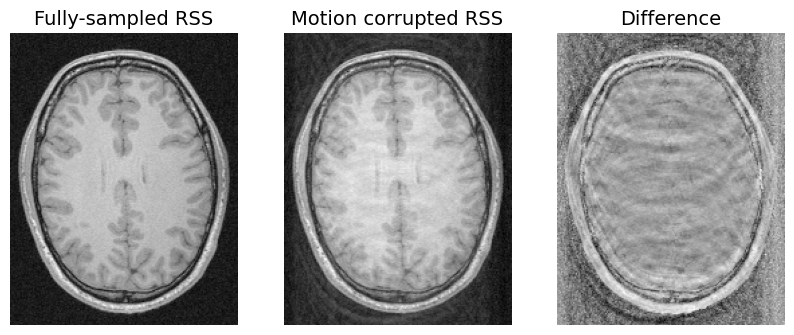

In [31]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rss_target, cmap='gray')
plt.title(f'Fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(motion_corrupted_rss_target, cmap='gray')
plt.title(f'Motion corrupted RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(torch.abs(rss_target) - torch.abs(motion_corrupted_rss_target), cmap='gray')
plt.title('Difference', fontsize=14)
plt.axis('off')
plt.show()

# Noise 2 Recon

In [32]:
# initialize the transformer
n2r_masking = N2R(
    probability=1.0,
    std_devs=(0.4, 0.4),
    rhos=(0.4, 0.4),
    use_mask=False,
)

In [33]:
# call the transformer
n2r_mask = n2r_masking(kspace, mask_5x)
n2r_masked_kspace = masked_kspace * n2r_mask
# apply the IFFT
n2r_masked_imspace = fft.ifft2(n2r_masked_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
n2r_masked_imspace = n2r_masked_imspace / torch.max(torch.abs(n2r_masked_imspace))
# compute the RSS target
n2r_masked_rss_target = utils.rss_complex(n2r_masked_imspace, coil_dim)

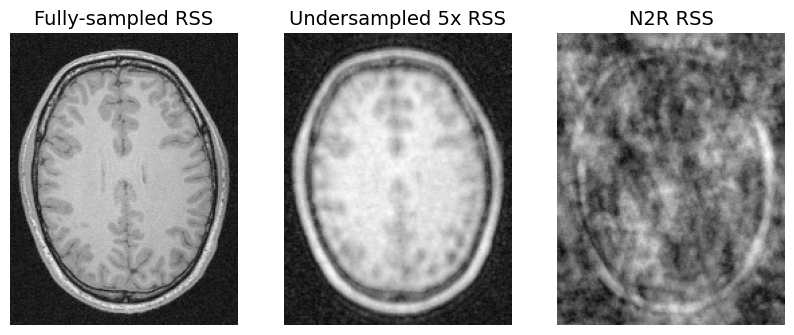

In [34]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rss_target, cmap='gray')
plt.title(f'Fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(masked_rss_target, cmap='gray')
plt.title(f'Undersampled 5x RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(n2r_masked_rss_target, cmap='gray')
plt.title(f'N2R RSS', fontsize=14)
plt.axis('off')
plt.show()

# Noise Prewhitening

In [35]:
# initialize the transformer
noise_prewhitening = NoisePreWhitening(
    find_patch_size=False,
    patch_size=patch_size,
    scale_factor=1.0,
    fft_centered=fft_centered,
    fft_normalization=fft_normalization,
    spatial_dims=spatial_dims,
)

In [36]:
# call the transformer
prewhitened_kspace = noise_prewhitening(kspace)
# apply the IFFT
prewhitened_imspace = fft.ifft2(prewhitened_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
prewhitened_imspace = prewhitened_imspace / torch.max(torch.abs(prewhitened_imspace))
# compute the SNR for the transformed image
prewhitened_imspace_snr = snr_estimator(prewhitened_imspace)
# stack all coils for visualization
prewhitened_imspace_all_coils = torch.view_as_complex(torch.cat([prewhitened_imspace[i] for i in range(num_coils)], dim=-2))
# compute the RSS target
prewhitened_rss_target = utils.rss_complex(prewhitened_imspace, coil_dim)
# compute the covariance matrix
covariance_prewhitened_imspace_all_coils = torch.abs(prewhitened_imspace_all_coils) @ torch.abs(prewhitened_imspace_all_coils).conj().T

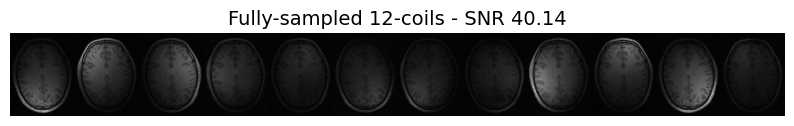

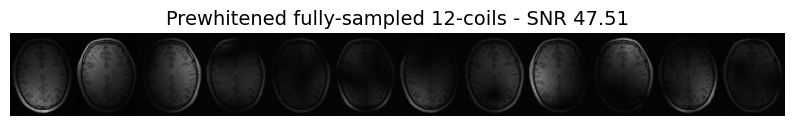

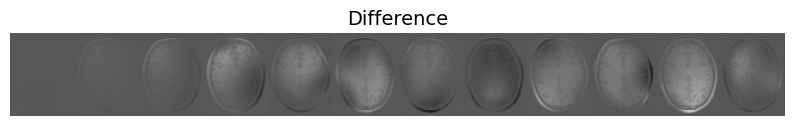

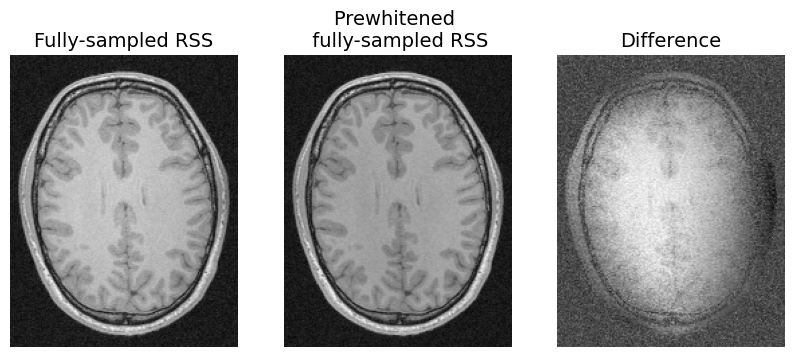

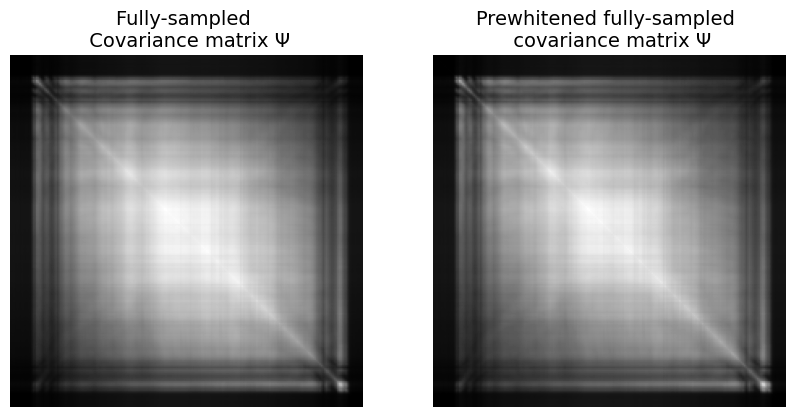

In [37]:
plt.figure(figsize=(10, 10))
plt.imshow(torch.abs(imspace_all_coils), cmap='gray')
plt.title(f'Fully-sampled {num_coils}-coils - SNR {imspace_snr:.2f}', fontsize=14)
plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(torch.abs(prewhitened_imspace_all_coils), cmap='gray')
plt.title(f'Prewhitened fully-sampled {num_coils}-coils - SNR {prewhitened_imspace_snr:.2f}', fontsize=14)
plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(torch.abs(imspace_all_coils) - torch.abs(prewhitened_imspace_all_coils), cmap='gray')
plt.title('Difference', fontsize=14)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rss_target, cmap='gray')
plt.title('Fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(prewhitened_rss_target, cmap='gray')
plt.title('Prewhitened \n fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(torch.abs(rss_target) - torch.abs(prewhitened_rss_target), cmap='gray')
plt.title('Difference', fontsize=14)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(covariance_imspace_all_coils, cmap='gray')
plt.title('Fully-sampled \n Covariance matrix Ψ', fontsize=14)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(covariance_prewhitened_imspace_all_coils, cmap='gray')
plt.title('Prewhitened fully-sampled \n covariance matrix Ψ', fontsize=14)
plt.axis('off')
plt.show()

# Self-Supervised Data Undersampling (SSDU)

In [38]:
# initialize the transformer
ssdu_masking = SSDU(
    mask_type="Gaussian",
    rho=0.4,
    acs_block_size=(4, 4),
    gaussian_std_scaling_factor=4.0,
    outer_kspace_fraction=0.0,
    export_and_reuse_masks=False,
)

In [39]:
# call the transformer
ssdu_train_mask, ssdu_loss_mask = ssdu_masking(kspace, mask_5x.squeeze(), subject)
ssdu_train_masked_kspace = kspace * ssdu_train_mask.unsqueeze(0).unsqueeze(-1)
ssdu_loss_masked_kspace = kspace * ssdu_loss_mask.unsqueeze(0).unsqueeze(-1)
# apply the IFFT
ssdu_train_masked_imspace = fft.ifft2(ssdu_train_masked_kspace, fft_centered, fft_normalization, spatial_dims)
ssdu_loss_masked_imspace = fft.ifft2(ssdu_loss_masked_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
ssdu_train_masked_imspace = ssdu_train_masked_imspace / torch.max(torch.abs(ssdu_train_masked_imspace))
ssdu_loss_masked_imspace = ssdu_loss_masked_imspace / torch.max(torch.abs(ssdu_loss_masked_imspace))
# compute the RSS target
ssdu_train_masked_rss_target = utils.rss_complex(ssdu_train_masked_imspace, coil_dim)
ssdu_loss_masked_rss_target = utils.rss_complex(ssdu_loss_masked_imspace, coil_dim)

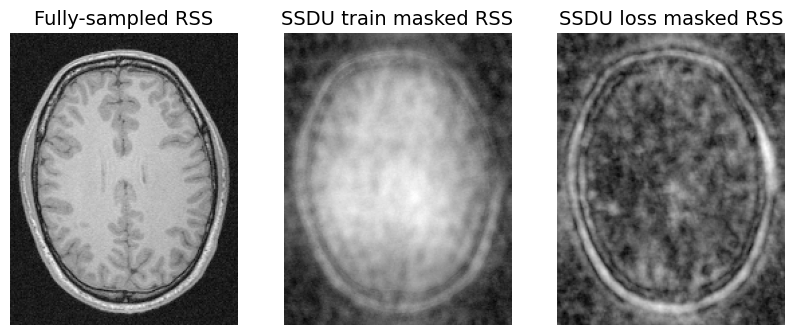

In [40]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rss_target, cmap='gray')
plt.title(f'Fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(ssdu_train_masked_rss_target, cmap='gray')
plt.title(f'SSDU train masked RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(ssdu_loss_masked_rss_target, cmap='gray')
plt.title(f'SSDU loss masked RSS', fontsize=14)
plt.axis('off')
plt.show()

# Zero-Filling k-space

In [41]:
# initialize the transformer
kspace_zero_filling = ZeroFillingPadding(
    zero_filling_size=(300, 300),
    fft_centered=fft_centered,
    fft_normalization=fft_normalization,
    spatial_dims=spatial_dims,
)

In [42]:
# call the transformer
kspace_zero_filled = kspace_zero_filling(kspace)
# apply the IFFT
imspace_zero_filled = fft.ifft2(kspace_zero_filled, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
imspace_zero_filled = imspace_zero_filled / torch.max(torch.abs(imspace_zero_filled))
# compute the RSS target
imspace_zero_filled_rss_target = utils.rss_complex(imspace_zero_filled, coil_dim)

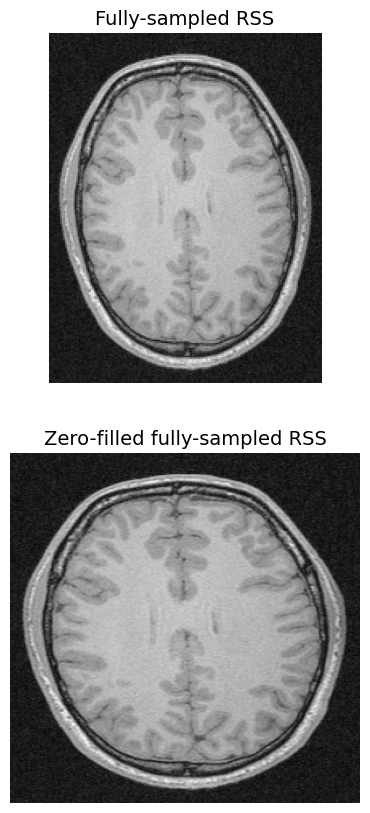

In [43]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.imshow(rss_target, cmap='gray')
plt.title('Fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(imspace_zero_filled_rss_target, cmap='gray')
plt.title(f'Zero-filled fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.show()

# Composer

In [44]:
gdcc_noise_prewhitening = Composer([noise_prewhitening, gdcc])

In [45]:
# call the transformer
coil_compressed_prewhitened_kspace = gdcc_noise_prewhitening(kspace)
# apply the IFFT
coil_compressed_prewhitened_imspace = fft.ifft2(coil_compressed_prewhitened_kspace, fft_centered, fft_normalization, spatial_dims)
coil_compressed_prewhitened_imspace = torch.flip(coil_compressed_prewhitened_imspace, [2])
# normalize the image for consistent visualization
coil_compressed_prewhitened_imspace = coil_compressed_prewhitened_imspace / torch.max(torch.abs(coil_compressed_prewhitened_imspace))
# compute the SNR for the transformed image
coil_compressed_prewhitened_imspace_snr = snr_estimator(coil_compressed_prewhitened_imspace)
# stack all coils for visualization
coil_compressed_prewhitened_imspace_all_coils = torch.view_as_complex(torch.cat([coil_compressed_prewhitened_imspace[i] for i in range(virtual_coils)], dim=-2))
# compute the SNR for the transformed image
coil_compressed_prewhitened_rss_target = utils.rss_complex(coil_compressed_prewhitened_imspace, coil_dim)
# compute the covariance matrix
covariance_coil_compressed_prewhitened_imspace_all_coils = torch.abs(coil_compressed_prewhitened_imspace_all_coils) @ torch.abs(coil_compressed_prewhitened_imspace_all_coils).conj().T

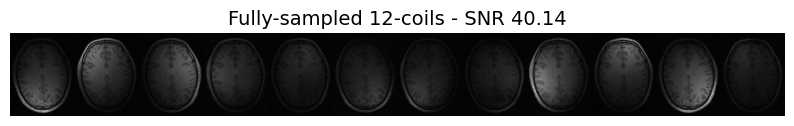

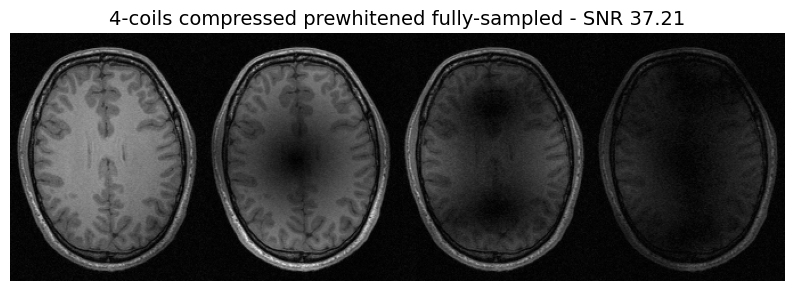

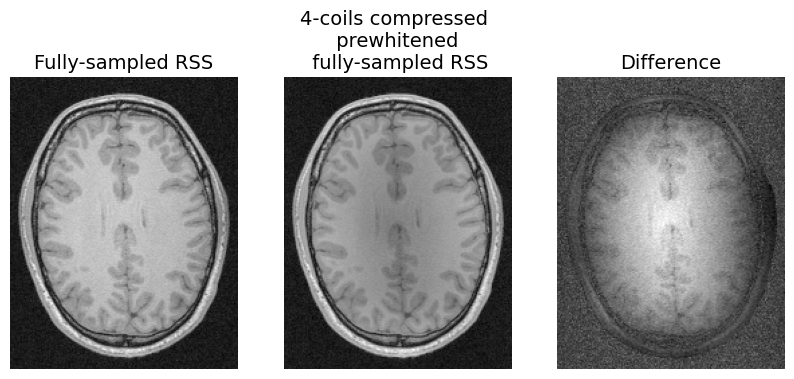

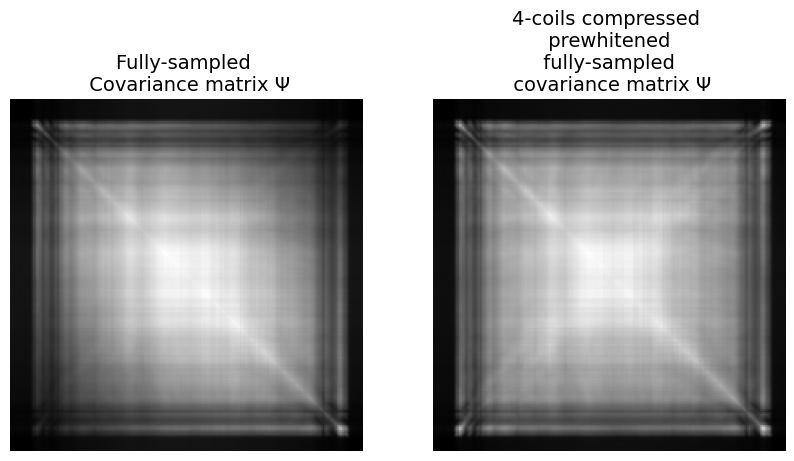

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(torch.abs(imspace_all_coils), cmap='gray')
plt.title(f'Fully-sampled {num_coils}-coils - SNR {imspace_snr:.2f}', fontsize=14)
plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(torch.abs(coil_compressed_prewhitened_imspace_all_coils), cmap='gray')
plt.title(f'{virtual_coils}-coils compressed prewhitened fully-sampled - SNR {coil_compressed_prewhitened_imspace_snr:.2f}', fontsize=14)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rss_target, cmap='gray')
plt.title('Fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(coil_compressed_prewhitened_rss_target, cmap='gray')
plt.title(f'{virtual_coils}-coils compressed \n prewhitened \n fully-sampled RSS', fontsize=14)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(torch.abs(rss_target) - torch.abs(coil_compressed_prewhitened_rss_target), cmap='gray')
plt.title('Difference', fontsize=14)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(covariance_imspace_all_coils, cmap='gray')
plt.title('Fully-sampled \n Covariance matrix Ψ', fontsize=14)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(covariance_coil_compressed_prewhitened_imspace_all_coils, cmap='gray')
plt.title(f'{virtual_coils}-coils compressed \n prewhitened \n fully-sampled \n covariance matrix Ψ', fontsize=14)
plt.axis('off')
plt.show()